### Pavithra Solai Jawahar | Test Accuracy = 91.26%

#### Using Transfer learning -  The model is trained with an image set having reduced image size of 24x24 for 15 epochs. This is then

#### used as a pre-trained model for the model using 32x32 images for 35 epochs to get an accuracy of 91.26% 

*The last two layers which has the flatten and the fully connected layers of the 24x24 model are removed while transfering the weights to 32x32 and later both the layers are added to 32x32 model*

In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

/home/ubuntu/anaconda3/envs/keras_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/keras_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/keras_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 50
l = 12
num_filter = 64
compression = 1
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
import numpy as np
import skimage
from skimage import transform
img = x_train[0]

x_train_24x24 = []
x_test_24x24 = []

print(x_train.shape[0])
for i in range(0,x_train.shape[0]):
  x_train_24x24.append(skimage.transform.resize(x_train[i],(24,24)))
for i in range(0,x_test.shape[0]):
  x_test_24x24.append(skimage.transform.resize(x_test[i],(24,24)))

x_train_24x24 = np.array(x_train_24x24)
x_test_24x24 = np.array(x_test_24x24)
img_height, img_width, channel = x_train_24x24.shape[1],x_train_24x24.shape[2],x_train_24x24.shape[3]
img_height, img_width, channel


50000


/home/ubuntu/anaconda3/envs/keras_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(24, 24, 3)

In [6]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [7]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [8]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [9]:
#num_filter = 12
#dropout_rate = 0.2
#l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)
#Second_Conv2D = Conv2D(32, (1,7), use_bias=False ,padding='same')(First_Conv2D)
#Third_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(Second_Conv2D)


First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 24, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 24, 24, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator( featurewise_center=True,
                          featurewise_std_normalization=True,
                          rotation_range=20, 
                          width_shift_range=0.2, 
                          #shear_range=0.2,
                          height_shift_range=0.2, 
                          zoom_range=0.15,
                          horizontal_flip=True)

gen.fit(x_train_24x24)
valid_gen = ImageDataGenerator()
train_generator = gen.flow(x_train_24x24, y_train, batch_size=batch_size)
validation_generator = valid_gen.flow(x_test_24x24, y_test, batch_size=batch_size)

In [12]:
# determine Loss function and Optimizer
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
import os

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=4, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

checkpoint = ModelCheckpoint('./weights/weights_24x24.{epoch:04d}-{val_loss:.2f}.hdf5',
                             monitor='val_loss', 
                             save_best_only=True )

logger = CSVLogger(os.path.join("./training", "training_24x24.log"))

callbacks_list = [reduce_lr,checkpoint,logger]

model_info_24x24 = model.fit(x_train_24x24, y_train,
                                batch_size=batch_size,
                                epochs=15,
                                callbacks = callbacks_list,
                                verbose=1,
                                validation_data=(x_test_24x24, y_test))

#model_info_24x24 =  model.fit_generator(train_generator, 
#                                        steps_per_epoch=train_generator.n//batch_size, 
#                                        epochs=2, 
#                                        callbacks=callbacks_list, 
#                                        verbose =1,
#                                        validation_data=validation_generator, 
#                                        validation_steps=validation_generator.n//batch_size)


Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 127s 3ms/step - loss: 1.4403 - acc: 0.4715 - val_loss: 1.8736 - val_acc: 0.4806
Epoch 2/15
50000/50000 [==============================] - 114s 2ms/step - loss: 0.9573 - acc: 0.6576 - val_loss: 1.6815 - val_acc: 0.5261
Epoch 3/15
50000/50000 [==============================] - 114s 2ms/step - loss: 0.7596 - acc: 0.7341 - val_loss: 1.7918 - val_acc: 0.5568
Epoch 4/15
50000/50000 [==============================] - 114s 2ms/step - loss: 0.6386 - acc: 0.7776 - val_loss: 1.3211 - val_acc: 0.6330
Epoch 5/15
50000/50000 [==============================] - 114s 2ms/step - loss: 0.5574 - acc: 0.8087 - val_loss: 1.3209 - val_acc: 0.6381
Epoch 6/15
50000/50000 [==============================] - 114s 2ms/step - loss: 0.4928 - acc: 0.8287 - val_loss: 0.7853 - val_acc: 0.7821
Epoch 7/15
50000/50000 [==============================] - 114s 2ms/step - loss: 0.4456 - acc: 0.8439 - val_loss: 0.9416 - 

### Training log for first 15 epochs

**epoch,acc,loss,lr,val_acc,val_loss**

0,0.47154,1.4402812793922424,0.001,0.4806,1.8736328044891357<br>
1,0.6576,0.9572634481430053,0.001,0.5261,1.681471136856079<br>
2,0.73412,0.7595961325645447,0.001,0.5568,1.7918406929016113 <br>
3,0.77756,0.6386098675346374,0.001,0.633,1.321125154876709<br>
4,0.80868,0.5574387101745606,0.001,0.6381,1.3209480113983154<br>
5,0.82866,0.4927969006729126,0.001,0.7821,0.7853054239273072<br>
6,0.84388,0.4455675366973877,0.001,0.7401,0.9415639285564422<br>
7,0.86198,0.39450712621688844,0.001,0.7803,0.7499400666058064<br>
8,0.87548,0.35669993549346923,0.001,0.7476,0.949484980916977<br>
9,0.88748,0.32472711835861207,0.001,0.7877,0.7731554038047791<br>
10,0.89906,0.28631033814430235,0.001,0.75,1.0838204488754273<br>
11,0.9072,0.2626846956205368,0.001,0.8073,0.7077724212169647<br>
12,0.91716,0.23483209190785884,0.001,0.789,0.837093390417099<br>
13,0.92472,0.212694515966177,0.001,0.8083,0.7604048787593841<br>
14,0.93484,0.1857212597179413,0.001,0.765,1.1218814019918442<br>

*This notebook was run using nbconvert as a background process, hence all the epoch runs were not captured, hence the training log*

In [13]:
#Last two layers (Flatten and FC) removed from 24x24 model
model.layers.pop()
model.layers.pop()
model.summary()
model.save_weights("DNST_model_24x24.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 24, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 24, 24, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

/home/ubuntu/anaconda3/envs/keras_p36/lib/python3.6/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


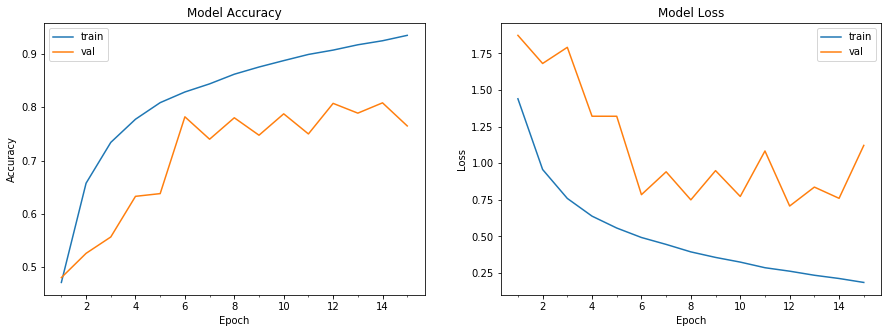

In [16]:
plot_model_history(model_info_24x24)

In [17]:
#Creating the 32x32 model without the last two layers
input_1 = Input(shape=(32, 32, 3,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input_1)
#Second_Conv2D = Conv2D(num_filter, (1,7), use_bias=False ,padding='same')(First_Conv2D)
#Third_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(Second_Conv2D)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
BatchNorm = BatchNormalization()(Last_Block)
relu = Activation('relu')(BatchNorm)
AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    

model_32x32 = Model(inputs=[input_1], outputs=[AvgPooling])
model_32x32.summary()

model_32x32.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
#Loading weights from 24x24 model
model_32x32.load_weights('DNST_model_24x24.h5')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 32, 32, 64)   1728        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 32, 32, 64)   256         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 32, 32, 64)   0           batch_normalization_53[0][0]     
__________________________________________________________________________________________________
conv2d_54 

In [18]:
# Adding the last two layers to create a connected model

#connecting_input = model_32x32.layers[-1].output
flat = Flatten()(model_32x32.output)
output = Dense(num_classes, activation='softmax')(flat)

model = Model(inputs=[model_32x32.input],outputs=[output])

    

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [20]:
gen = ImageDataGenerator( #featurewise_center=True,
                          #featurewise_std_normalization=True,
                          rotation_range=20, 
                          width_shift_range=0.2, 
                          #shear_range=0.2,
                          height_shift_range=0.2, 
                          zoom_range=0.15,
                          horizontal_flip=True)

valid_gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = valid_gen.flow(x_test, y_test, batch_size=batch_size)

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=3, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

checkpoint = ModelCheckpoint('./weights/weights_32x32.{epoch:04d}-{val_loss:.2f}.hdf5',
                             monitor='val_loss', 
                             save_best_only=True )

logger = CSVLogger(os.path.join("./training", "training_32x32.log"))

callbacks_list = [reduce_lr,checkpoint,logger]

model_info_32x32= model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=(x_test, y_test))


#model_info_32x32 =  model.fit_generator(train_generator, 
#                                        steps_per_epoch=train_generator.n//batch_size, 
#                                        epochs=2, 
#                                        callbacks=callbacks_list, 
#                                        verbose =1,
#                                        validation_data=validation_generator, 
#                                        validation_steps=validation_generator.n//batch_size)


Train on 50000 samples, validate on 10000 samples
Epoch 1/35
50000/50000 [==============================] - 180s 4ms/step - loss: 0.3491 - acc: 0.8817 - val_loss: 0.5226 - val_acc: 0.8532
Epoch 2/35
50000/50000 [==============================] - 167s 3ms/step - loss: 0.2474 - acc: 0.9152 - val_loss: 0.7839 - val_acc: 0.8042
Epoch 3/35
50000/50000 [==============================] - 167s 3ms/step - loss: 0.2071 - acc: 0.9285 - val_loss: 0.6155 - val_acc: 0.8329
Epoch 4/35
50000/50000 [==============================] - 167s 3ms/step - loss: 0.1770 - acc: 0.9386 - val_loss: 0.5816 - val_acc: 0.8585
Epoch 5/35
50000/50000 [==============================] - 167s 3ms/step - loss: 0.0851 - acc: 0.9712 - val_loss: 0.3930 - val_acc: 0.9056
Epoch 6/35
50000/50000 [==============================] - 167s 3ms/step - loss: 0.0578 - acc: 0.9810 - val_loss: 0.4167 - val_acc: 0.9072
Epoch 7/35
50000/50000 [==============================] - 167s 3ms/step - loss: 0.0490 - acc: 0.9832 - val_loss: 0.4537 - 

### Training log for 35 epochs

**epoch,acc,loss,lr,val_acc,val_loss**<br>
0,0.88174,0.34911525221824646,0.001,0.8532,0.5226464922904969<br>
1,0.91518,0.24741484283447265,0.001,0.8042,0.783930686980486<br>
2,0.92854,0.207124305768013,0.001,0.8329,0.6154593685865403<br>
3,0.93864,0.1770228044986725,0.001,0.8585,0.5816434691041708<br>
4,0.97118,0.08512309893965721,0.000100000005,0.9056,0.39299768939614294<br>
5,0.98104,0.05781089392900467,0.000100000005,0.9072,0.41669612444639204<br>
6,0.98324,0.04899225570380688,0.000100000005,0.9062,0.45374522292613984<br>
7,0.9857,0.04182282339781523,0.000100000005,0.9088,0.45795964899063113<br>
8,0.98848,0.03365639775365591,1.0000001e-05,0.9127,0.43978785140514376<br>
9,0.98924,0.03196870920792222,1.0000001e-05,0.9132,0.43947560489177706<br>
10,0.98962,0.030332731713056563,1.0000001e-05,0.9124,0.4397365136384964<br>
11,0.99028,0.02892625658132136,1.0000001e-06,0.9122,0.4397587626695633<br>
12,0.9902,0.030031971413493157,1.0000001e-06,0.9133,0.4411399585723877<br>
13,0.99068,0.028117527407482266,1.0000001e-06,0.9124,0.4422413051366806<br>
14,0.99038,0.02831381629059091,1.0000001e-07,0.9127,0.44000246241092683<br>
15,0.99054,0.028562240248322487,1.0000001e-07,0.9123,0.44437151188850404<br>
16,0.9899,0.0292011460147053,1.0000001e-07,0.9123,0.4417844720363617<br>
17,0.99126,0.02748494241781533,1.0000001e-08,0.9128,0.4413228589773178<br>
18,0.99082,0.027918666636906564,1.0000001e-08,0.9126,0.4420756635427475<br>
19,0.99038,0.02903096145167947,1.0000001e-08,0.9133,0.43836644179821016<br>
20,0.9906,0.028765261491984127,1.0000001e-09,0.9119,0.4445704698324203<br>
21,0.99024,0.029086237516999246,1.0000001e-09,0.9127,0.44240386190414427<br>
22,0.99028,0.029501601093262435,1.0000001e-09,0.9126,0.44002898969650267<br>
23,0.99048,0.029152782361358404,1.0000001e-10,0.9126,0.44268333461284637<br>
24,0.99054,0.028636229846030474,1.0000001e-10,0.9126,0.4415939107656479<br>
25,0.9905,0.028582430528104306,1.0000001e-10,0.913,0.4408603743314743<br>
26,0.99072,0.027994074228554964,1.0000001e-11,0.9128,0.4413929399728775<br>
27,0.99016,0.029658195477575065,1.0000001e-11,0.9122,0.4423948252916336<br>
28,0.99024,0.029018354065865278,1.0000001e-11,0.9128,0.43881297042369843<br>
29,0.99038,0.02918599838025868,1.0000001e-12,0.9132,0.4391292317867279<br>
30,0.99058,0.02858233099371195,1.0000001e-12,0.9129,0.44049913749694825<br>
31,0.99106,0.027797619905769826,1.0000001e-12,0.9125,0.44202368898391725<br>
32,0.99082,0.027825321543812752,1.0000001e-13,0.9132,0.4402481426000595<br>
33,0.99102,0.02820061611250043,1.0000001e-13,0.9124,0.44161188185214995<br>
34,0.99088,0.028003212239444256,1.0000001e-13,0.9126,0.43957280044555663<br>
 

In [22]:
# Test the model
#model.load_weights('./weights/weights_32x32.0014-0.36.hdf5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


10000/10000 [==============================] - 13s 1ms/step
Test loss: 0.4395727689050138
Test accuracy: 0.9126


### Test Accuracy  : 91.26% with loss = 0.43

In [23]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_32x32.h5")
print("Saved model to disk")

Saved model to disk


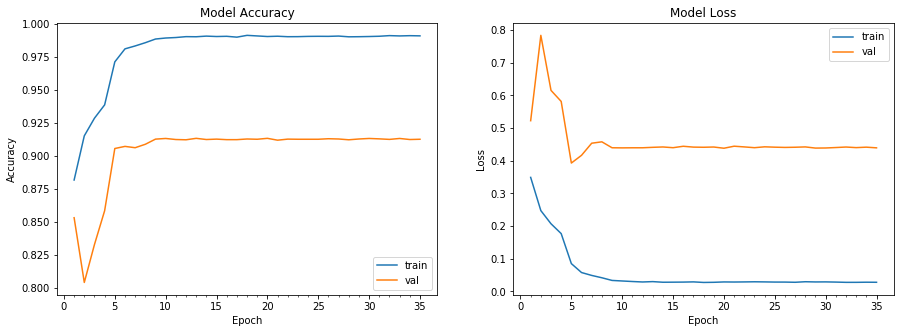

In [24]:
plot_model_history(model_info_32x32)